### Langgrah Chain
Review
We built a simple graph with nodes, normal edges, and conditional edges.

Goals
Now, let's build up to a simple chain that combines 4 concepts:

Using chat messages as our graph state
Using chat models in graph nodes
Binding tools to our chat model
Executing tool calls in graph nodes

In [1]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching Nvidia stock?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about Nvidia stock .", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the how Nvidia stock perform in future.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching Nvidia stock?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about Nvidia stock .
================================ Human Message =================================
Name: Lance

I want to learn about the how Nvidia stock perform in future.


In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [3]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="qwen-qwq-32b")
result=llm.invoke(messages)
result

AIMessage(content='\n<think>\nOkay, the user wants to know how Nvidia\'s stock will perform in the future. Let me start by recalling the key factors that influence stock performance. First, I should consider the company\'s recent performance and trends. Nvidia has been doing well in AI and gaming, so that\'s a positive sign. But I should also think about potential risks like economic downturns or supply chain issues.\n\nI need to break down the analysis into sections. Maybe start with market drivers, then challenges, and then the broader economic context. Also, including historical performance could provide a baseline. The user might not be familiar with technical terms, so I should explain things clearly without too much jargon.\n\nWait, they mentioned future performance, so maybe forecasting methods are important. Analysts often use EPS growth, revenue projections, and P/E ratios. I should mention those and explain what they mean. Also, factors like the AI boom and data center demand

# Langgraph with tools

In [26]:
def mul(a:int,b:int)->int:
    """ Mul a and b
    Args:
    a:first int
    b:second int
    """ 
    return a*b

In [27]:
llm_with_tools=llm.bind_tools([mul])

In [28]:
tool_call=llm_with_tools.invoke([HumanMessage(content=f"What is 2 mul 3")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_SonbAQ6KZdIeFA8ePUSRs37h', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'mul'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 65, 'total_tokens': 83, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f7a584cf1f', 'id': 'chatcmpl-BO3rZsHq5Q6qprvNFF1zlZbuMJMLt', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9fc175fd-75d7-4895-a802-87d08c923fbb-0', tool_calls=[{'name': 'mul', 'args': {'a': 2, 'b': 3}, 'id': 'call_SonbAQ6KZdIeFA8ePUSRs37h', 'type': 'tool_call'}], usage_metadata={'input_tokens': 65, 'output_tokens': 18, 'total_tokens': 83, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audi

In [29]:
tool_call.tool_calls

[{'name': 'mul',
  'args': {'a': 2, 'b': 3},
  'id': 'call_SonbAQ6KZdIeFA8ePUSRs37h',
  'type': 'tool_call'}]

## Langgraph message add

In [30]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

In [31]:
class MessageState(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [32]:
initial_message=[AIMessage(content="Hello! I am financial expert how can I help you?",name="model"),
                 HumanMessage(content="I want to know about Microsoft stock growth",name="Rahul")]

# new  messsage to add
new_message=AIMessage(content="Sure,I can help with that ,Are you looking for future investement? ",name="model")
add_messages(initial_message,new_message)

[AIMessage(content='Hello! I am financial expert how can I help you?', additional_kwargs={}, response_metadata={}, name='model', id='20f0786b-c3b9-4806-a2b3-c61d5d4da588'),
 HumanMessage(content='I want to know about Microsoft stock growth', additional_kwargs={}, response_metadata={}, name='Rahul', id='490aeb8e-3b1a-4d4a-b469-86bf221eb58c'),
 AIMessage(content='Sure,I can help with that ,Are you looking for future investement? ', additional_kwargs={}, response_metadata={}, name='model', id='76cd5359-ff70-4d59-8baa-179f77109ae5')]

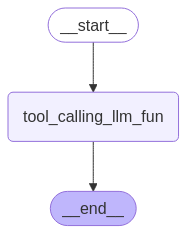

In [33]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END

# node
def tool_calling_llm_fun(state:MessageState):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build the graph
graph_builder=StateGraph(MessageState)
graph_builder.add_node("tool_calling_llm_fun",tool_calling_llm_fun)
graph_builder.add_edge(START,"tool_calling_llm_fun")
graph_builder.add_edge("tool_calling_llm_fun",END)

graph=graph_builder.compile()

#view
display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
messages=graph.invoke({"messages":HumanMessage(content="What is 2 mul 3")})


In [35]:
messages['messages']


[HumanMessage(content='What is 2 mul 3', additional_kwargs={}, response_metadata={}, id='87885c33-cb4b-4c7a-82bd-f0c9bd6a0155'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_CbFrV6IPnjcpmpLdUwBvLEkI', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'mul'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 65, 'total_tokens': 83, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f7a584cf1f', 'id': 'chatcmpl-BO3rrtQg6v6psaG3w4hyJee3effRD', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-501f68ea-1ed9-4bef-8062-9b3e6af41b3e-0', tool_calls=[{'name': 'mul', 'args': {'a': 2, 'b': 3}, 'id': 'call_CbFrV6IPnjcpmpLdUwBvLEkI', 'type': 'tool_call'}], usage_metadata={'input_tokens':

In [36]:
from langchain_openai import ChatOpenAI

def substraction(a: int, b: int) -> int:
    """Substract and b.

    Args:
        a: first int
        b: second int
    """
    return a - b

In [37]:
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

### Tools
Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language.

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user.

And, it will return an output that adheres to the tool's schema.

Many LLM providers support tool calling and tool calling interface in LangChain is simple.

You can simply pass any Python function into ChatModel.bind_tools(function).

In [38]:
llm=ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello openAI")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 10, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f7a584cf1f', 'id': 'chatcmpl-BO3s2AjCHWXKJroTEbw4UkKO1GSJq', 'finish_reason': 'stop', 'logprobs': None}, id='run-5d1982f7-9f72-4821-9c37-61cadf0c73a1-0', usage_metadata={'input_tokens': 10, 'output_tokens': 10, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [39]:
llm_with_tools=llm.bind_tools([mul,substraction])

In [40]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState




In [41]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

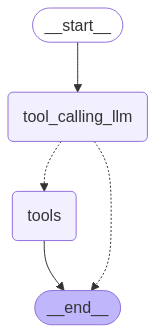

In [42]:
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([mul,substraction]))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
#builder.add_edge("tool2", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [45]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Sub 3 and 4 and  mul the output by 2 ")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Sub 3 and 4 and  mul the output by 2 
================================== Ai Message ==================================
Tool Calls:
  substraction (call_WYtLJjc37VdoUe5VTsTilza3)
 Call ID: call_WYtLJjc37VdoUe5VTsTilza3
  Args:
    a: 3
    b: 4
  mul (call_mRjgEuHDeGqFdCMnCCtkkCJN)
 Call ID: call_mRjgEuHDeGqFdCMnCCtkkCJN
  Args:
    a: -1
    b: 2
================================= Tool Message =================================
Name: substraction

-1
================================= Tool Message =================================
Name: mul

-2


In [25]:
 messages['messages']

[HumanMessage(content='Sub 3 and 4. Multiply the output by 2 and add 5.', additional_kwargs={}, response_metadata={}, id='5fbc5c0e-7043-4b01-9698-0f6b8993db0b'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hf8RaZ14wX5ZTbQLj5GBk0Rl', 'function': {'arguments': '{"a":3,"b":4}', 'name': 'substraction'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 107, 'total_tokens': 126, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f7a584cf1f', 'id': 'chatcmpl-BO3nVTEZre5wGb1c36rjCBwxPIodJ', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f3891bd6-3232-4aaf-9508-2f977e456a4a-0', tool_calls=[{'name': 'substraction', 'args': {'a': 3, 'b': 4}, 'id': 'call_hf8RaZ14wX5ZTbQLj5GBk0Rl', '